#Group members:
*   Abhijeet Pal (200100107)
*   Kanak Yadav (20D070044)


In [ ]:
#importing
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import PIL
import cv2
from google.colab.patches import cv2_imshow
from pywt import dwt2, idwt2

#1.

a. Add additive white Gaussian noise (AWGN) with variable variance to any given image, whether grayscale or color. The noise should be independent in RGB channels for color images.

In [ ]:
#function to add AWGN and return the noisy image
def awgn(image, variance, mean=0):
    
    """adds Additive White Gaussian Noise with variable variance to an array
    returns the noisy image array"""
    
    #copying the image array; standard deviation is the square root of the variance
    arr, std_dev = image.copy(), np.sqrt(variance)
    
    #source of inspiration : https://stackoverflow.com/questions/55261087/adding-gaussian-noise-to-image
    #check if it is a color image
    if arr.ndim == 3:

        #iterating over all the different color channels the image has
        for i in range(arr.shape[-1]):
            
            #generating the white gaussian noise with the required mean an varaince(or standard deviation)
            #for a color image, the image height and width are the first two values in the shape array
            #ndarray.astype(np.uint8) is required to conert the values to unsigned integer 8bit which cann be added to images
            noise = np.random.normal(mean, std_dev, arr.shape[:2]).astype(np.uint8)

            #adding noise the image
            arr[:, :, i] += noise

        #since the gaussian random noise is generated seperately for the different colors, they are independent.

    #else it is a grayscale image        
    else:

        #doing the same but only one channel
        noise = np.random.normal(mean, std_dev, arr.shape).astype(np.uint8)
        arr += noise
    
    #returning the noisy image
    return arr

b. Measure PSNR (with 255 as the default peak, but it should also be variable) between a restoredimage and a ground-truth image.

In [ ]:
#function to measure PSNR and return it
def meas_psnr(reimg, gtimg, peak=255):

    """measures the PSNR metric and returns it
    default peak = 255"""

    #finding the mean squared error:
    #   for grayscale it is straight forward
    #   for color image taken the idea from : https://dsp.stackexchange.com/questions/71845/defining-the-snr-or-psnr-for-color-images-3-channel-rgb-files
    #       i.e. to define the error as the L2-norm of the difference of the (b,g,r) vectors of the two images
    #   the expression used below works regardless of the image being grayscale or color
    mse = np.sum( (reimg - gtimg)**2 ) / reimg.size
    
    #calculating the psnr with the given or fixed (255) peak
    psnr = 10 * np.log10( peak**2 / mse )

    #returning the psnr metric
    return psnr

c. Measure SSIM (with power 1 for all three elements -- mean, variance, correlation -- which can be varied too) between a restored and a ground-truth image.

In [ ]:
#function to measure SSIM and return it
def meas_ssim(reimg, gtimg, powers=(1, 1, 1)):

    """measures the SSIM metric and returns it
    for color images returns an array of SSIM values
    for the different colors
    powers = (alpha, beta, gamma); default = (1, 1, 1)"""

    #defining required constants; source : https://en.wikipedia.org/wiki/Structural_similarity#Algorithm
    L = 255
    k1, k2 = 0.01, 0.03
    c1, c2 = (k1 * L)**2, (k2 * L)**2
    c3 = c2 / 2

    #creating lists for storing the mean of reimg, gtimg and their variances and covariances
    mux, muy, sigma2 = [], [], []

    #check if it is a color image
    if reimg.ndim == 3:

        #iterating over the different colors
        for i in range(reimg.shape[-1]):

            #calculating and storing the mean of the images
            mux.append(np.mean(reimg[:, :, i]))
            muy.append(np.mean(gtimg[:, :, i]))

            #calculating the variance of both the input arrays
            #(a specific color channel of both images) and their covariance.
            #source = https://stackoverflow.com/questions/15317822/calculating-covariance-with-python-and-numpy
            #according to the source, np.cov returns the array : [ [ cov(a, a) cov(a, b) ]
            #                                                      [ cov(a, b) cov(b, b) ] ]
            #note that cov(i, i) = var(i)
            cov_vec = np.cov(reimg[:, :, i].flatten(), gtimg[:, :, i].flatten())

            #storing the required stuff in the following format:
            #[ var(reimg), var(gtimg), cov(reimg, gtimg) ]
            sigma2.extend([cov_vec[0, 0], cov_vec[1, 1], cov_vec[0, 1]])
    
    #else it is a grayscale image
    else:

        #doing the same but only once
        mux.append(np.mean(reimg))
        muy.append(np.mean(gtimg))
        cov_vec = np.cov(reimg.flatten(), gtimg.flatten()).flatten()
        sigma2.extend([cov_vec[0], cov_vec[-1], cov_vec[1]])
    
    #converting the list to required arrays
    mux, muy = np.array(mux), np.array(muy)
    sigmax, sigmay = np.sqrt(np.array(sigma2[::3])), np.sqrt(np.array(sigma2[1::3]))
    sigmaxy = np.array(sigma2[2::3])

    #using array allowed us to use the same code for both gray and color images
    #caluculating the comparison measurements: luminance, contrast and structure
    l = ( 2 * mux * muy + c1) / ( mux**2 + muy**2 + c1)
    c = ( 2 * sigmax * sigmay + c2) / ( sigmax**2 + sigmay**2 + c2)
    s = ( sigmaxy + c3) / ( sigmax * sigmay + c3)

    #calculating the Structural Similarity Index Measure
    ssim = l**powers[0] * c**powers[1] * s**powers[2]
    
    #returning the SSIM metric
    return ssim

d. Isotropic Gaussian blurring (Gaussian low pass filtering) of an image for a given variance. 

In [ ]:
#defining Inverse Fourier Transform and Fourier Transform operations as functions
ift = lambda arr: np.fft.ifft2(np.fft.ifftshift(arr))
ft = lambda arr: np.fft.fftshift(np.fft.fft2(arr))

#function to perform isotropic gaussian blurring
def glpf(img, variance):
    """performs Gaussian Low Pass Filtering with the
    given variance and returns the resultant image"""

    #copying the image array
    arr = img.copy()

    #extracting its height and width dimensions
    h, w, *args = img.shape

    #constructing the gaussian low pass filter in frequency domain by first creating an array full of zeros
    filter = np.zeros((h, w))

    #then iterating over one-fourth of the array locations using the fact that the reflections of the point
    #in the top left from the horizontal and vertical axes are all equidistant from the center locatoin
    for u in range(h//2+1):
        for v in range(w//2+1):

            #assigning them with just the distance square as the rest of the operations can be done uniformly over the whole array
            filter[u, v] = filter[u, w - v - 1] = filter[h - u - 1, v] = filter[h - u - 1, w - v - 1] = (u - h//2)**2 + (v - w//2)**2

    #doing the remainder of the operations required to construct the glpf
    filter = np.exp( -filter / ( 2 * variance ) )

    #check if it is a color image
    if arr.ndim == 3:

        #iterate over all colors
        for i in range(arr.shape[-1]):

            #replace it with its filtered version
            #filtering is done in the frequency domain as the filter is being multipied to the fourier transform
            #and then the inverse fourier transform of that is stored in the image
            arr[:, :, i] = ift( ft( arr[:, :, i] ) * filter )
    
    #else it is a grayscale image
    else:

        #doing the same but just once
        arr = ift( ft( arr ) * filter )
    
    #returning the filtered image array
    return arr

testing the above functions on a test image

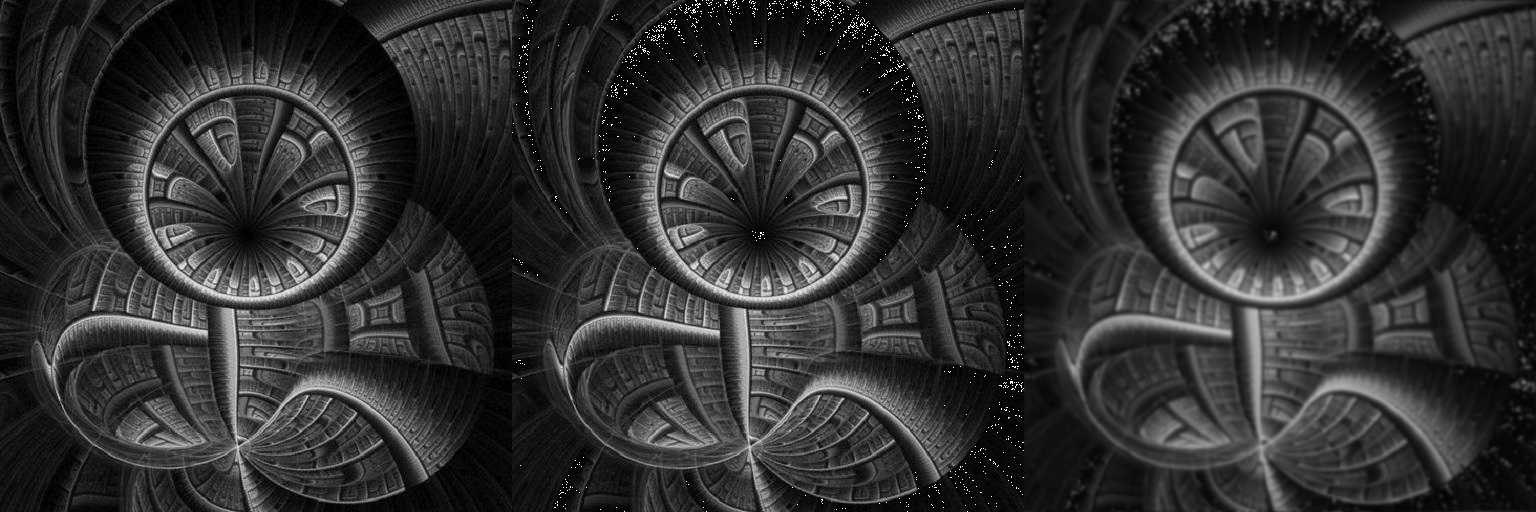

PSNR =  (25.101900370203257+0.0006470526557550635j)
SSIM =  [0.92882707+1.06539374e-05j]


In [ ]:
# We are now testing the above defined function on a test image testbw
# Loading the test image
testbw = cv2.imread("1.jpg", 0)
# Adding white Gaussian Noise to the image with variance 10
noisybw = awgn(testbw, 10)
# Restoring the image using Gaussian low pass filter and variance 2500
restoredbw = glpf(noisybw, 2500)
# Concatenating the images to show them side by side for better visualization
cv2_imshow(np.concatenate((testbw, noisybw, restoredbw), 1))
# Finding the PSNR and SSIM of the restored image
print('PSNR = ', meas_psnr(restoredbw, testbw))
print('SSIM = ', meas_ssim(restoredbw, testbw))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part


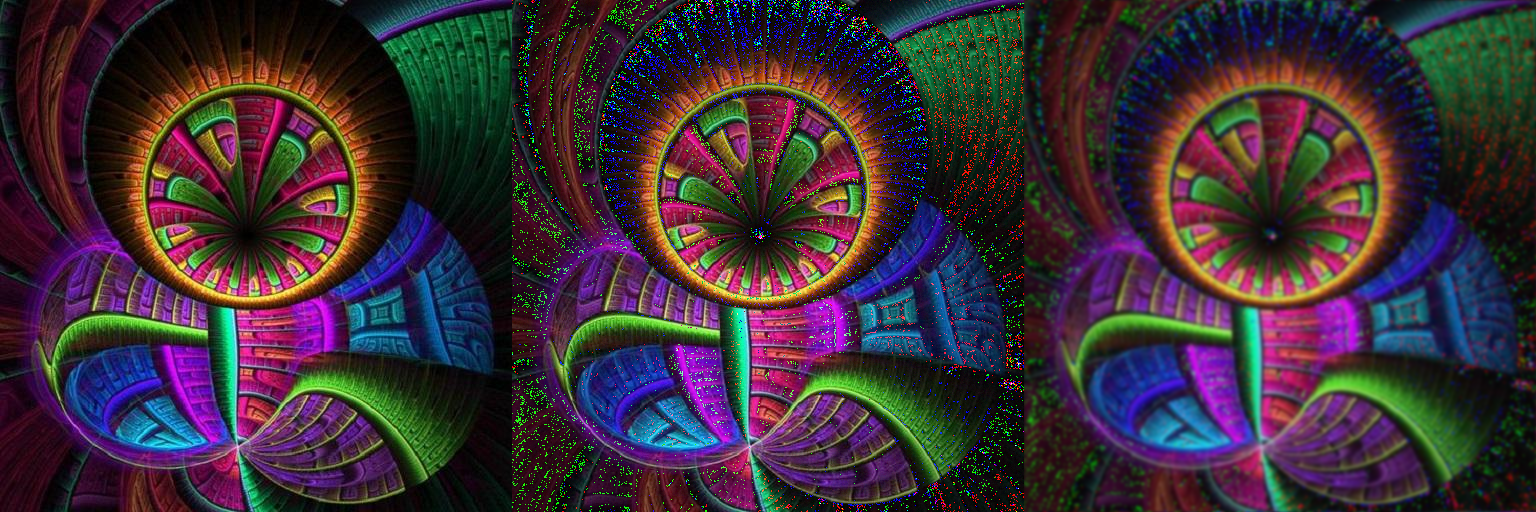

PSNR =  30.04446054053385
SSIM =  [0.88989542 0.88484761 0.93538375]


In [ ]:
# Testing the functions on a colored image
# Loading the test colored image testbgr
testbgr = cv2.imread("1.jpg", 1)
# Adding white gaussian noise to the image with variance of 10
noisybgr = awgn(testbgr, 10)
# Restoring the image with gaussian low pass filter of variance 2500
restoredbgr = glpf(noisybgr, 2500)
# Concatenating the images and showing them side by side for better visualization
cv2_imshow(np.concatenate((testbgr, noisybgr, restoredbgr), 1))
# Finding the PSNR and SSIM of the restored image
print('PSNR = ', meas_psnr(restoredbgr, testbgr))
print('SSIM = ', meas_ssim(restoredbgr, testbgr))

#2.

a.  Hard thresholding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold (thresholdshould be variable).

In [ ]:
#function to perform hard thresholding with variable threshold
def hard_thresholding(image, threshold):
    
    """function that performs hard thresholding with variable threshold on
    the wavelet transform of a grayscale image and returns the new image"""
    
    #extracting all the coefficients using the haar wavelet
    img = image.copy() 
    # Calculating the discrete wavelet transform of the image
    _, st = dwt2(img, 'haar')
    h, w = _.shape
    # Loop for finding the values below the threshold in the image 
    # and assigning those to 0
    for i in st:
        for u in range(h):
            for v in range(w):
                if abs(i[u, v]) < threshold:
                    i[u, v] = 0
    img = idwt2((_, st), 'haar')
    # Calculating the discrete wavelet transform of the image
    #returning the new image
    return img

b. Soft threhsolding: set to zero any detail (LH, HL, HH) coefficient that is below a threshold (thresholdshould be variable), and subtract the threshold from those that are above the threshold.

In [ ]:
#function to perform soft thresholding with variable threshold
def soft_thresholding(image, threshold):
    
    """function that performs soft thresholding with variable threshold on
    the wavelet transform of a grayscale image and returns the new image"""
    img = image.copy()
    # Calculating the discrete wavelet transform of the image
    _, st = dwt2(img, 'haar')
    h, w = _.shape
    # Loop for finding the coefficients which are less than 0 and also 
    # reducing positive coefficients by threshold value
    for i in st:
        for u in range(h):
            for v in range(w):
                if i[u, v] < 0:
                    i[u, v] = min(0, i[u, v] + threshold)
                else:
                    i[u, v] = max(0, i[u, v] - threshold)
    img = idwt2((_, st), 'haar')
    # Calculating inverse discrete wavelet transform of the image
    #returning the new image
    return img

c. The method proposed in the paper “Image Denoising using Neighbouring Wavelet Coefficients” byChen et al. https://www.egr.msu.edu/~aviyente/neighshrink.pdf

In [ ]:
#source: Assignment-2
def zero_padding(img, x):
  #np.concatenate joins the arrays in its first argumenr along the axes given as the second argument
  # first it pads the top and bottom if the image
  img = np.concatenate((np.zeros((x,img.shape[1])), img, np.zeros((x,img.shape[1]))), axis=0)
  # and then the left and right of the image
  img = np.concatenate((np.zeros((img.shape[0],x)), img, np.zeros((img.shape[0],x))), axis=1)
  return img


#function to perform NeighShrink
def neigh_shrink(image, variance=2, window_size=3):
    
    """function that performs neight shrink with variable threshold on
    the wavelet transform of a grayscale image and returns the new image"""
    img = image.copy()
    # Calculating the discrete wavelet transform of the image
    _, st = dwt2(img, 'haar')
    h, w = _.shape
    nst = []
    # nst -- representing new st stores the new values of the 
    # wavelet coefficients 
    for i in st:
        ni = i.copy()
        # We are initially zero padding the image for corner pixels and edge pixels
        i = zero_padding(i, (window_size-1)//2)
        for u in range(h):
            for v in range(w):
                if (u == 0 or u == h-1) and (v == 0 or v == w-1):
                    n = 4
                    # n=4 for the the 4 corners of the image i.e. cornermost pixels
                elif (u == 0 or u == h-1) or (v == 0 or v == w-1):
                    n = 6
                    # n=6 for the other edge pixels of the image that lie on the boundaries
                else:
                    n = 9
                    # n=9 for non-edge pixels
                
                l = np.sqrt( 2 * variance * np.log( n ** 2 ) )
                # calculating lambda as square root of 2*variance*log(n^2)
                ni[u, v] = max (
                    0,
                    1 - ( l ** 2 / np.sum( i[u:u+window_size, v:v+window_size] ** 2 ) )
                    )
                # The new coefficients are 0 if beta j,k is negative and 1-lambda square / S j,k square
        nst.append(ni)
        # appending the new calculated coefficient for pixel ni in nst
    nst = tuple(nst)
    img = idwt2((_, nst), 'haar')
    # Taking inverse wavelet transform
    #returning the new image
    return img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


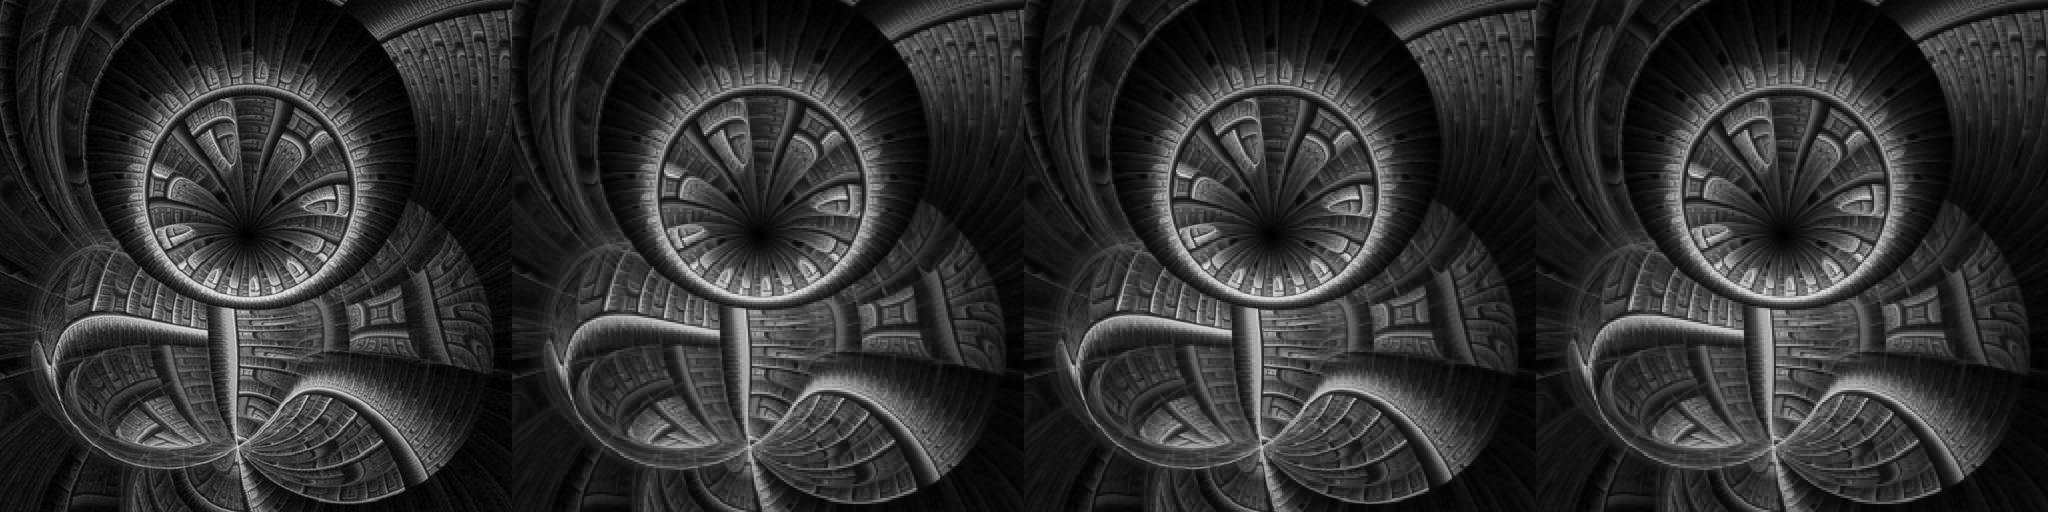

29.35997393343181
30.213676681006266
28.831138094281176
[0.97575388]
[0.98021429]
[0.97260036]


In [ ]:
# Testing the functions
# Testing soft_thresholding and hard_thresholding of the test image testbw
# with variance 50
a, b = soft_thresholding(testbw, 50), hard_thresholding(testbw, 50)
# Testing neight_shrink as proposed in Chen et al with variance 6
c = neigh_shrink(testbw, 6)
# Concatenating the images with the original images to show side by side for proper visualization
# Image order is original image, soft_thresholding, hard_thresholding, neigh_shrinking
cv2_imshow(np.concatenate((testbw, a, b, c), 1))
# Printing the psnr of all the images order is soft_thresholding, hard_thresholding, neigh_shrinking
print(meas_psnr(a, testbw), meas_psnr(b, testbw), meas_psnr(c, testbw), sep='\n')
# Printing the ssim of all the images order is soft_thresholding, hard_thresholding, neigh_shrinking
print(meas_ssim(a, testbw), meas_ssim(b, testbw), meas_ssim(c, testbw), sep='\n')

#3.

a. Noise variance

In [ ]:
varimg = cv2.imread('1.jpg', 1)
# Reading the image in RGB format
# Varying the variance of noise from 1 to 100
noise_var = range(1, 100)
# Lists psnr and ssim will hold the psnr and ssim values for each variance value
psnr, ssim = [], []
for var in noise_var:
    noisy = awgn(varimg, var)
    psnr.append(meas_psnr(noisy, varimg))
    ssim.append(meas_ssim(noisy, varimg))

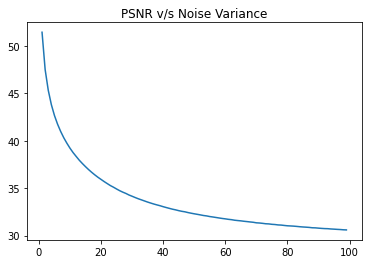

In [ ]:
# Plotting psnr vs noise variance 
plt.plot(noise_var, psnr)
plt.title('PSNR v/s Noise Variance')
plt.show()

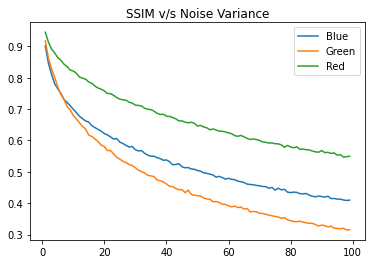

In [ ]:
# Plotting ssim vs noise variance
plt.plot(noise_var, ssim)
plt.title('SSIM v/s Noise Variance')
plt.legend(['Blue', 'Green', 'Red'])
plt.show()

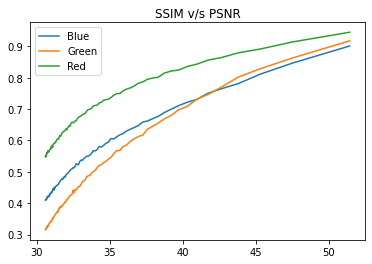

In [ ]:
# Plotting ssim vs psnr
plt.plot(psnr, ssim)
plt.title('SSIM v/s PSNR')
plt.legend(['Blue', 'Green', 'Red'])
plt.show()

b. Gaussian low pass filtering with various variances

In [ ]:
# Adding white guassian noise of variance 30 to initial image
base_var = 30
base_img = awgn(varimg, base_var)
# Varying gaussian low pass filter variance from 1 to 100
glpf_var = range(1, 100)
psnr, ssim = [], []
# psnr and ssim lists will contain the psnr and ssim values for each variance value 
for var in glpf_var:
    glpf_img = glpf(base_img, var)
    psnr.append(meas_psnr(glpf_img, varimg))
    ssim.append(meas_ssim(glpf_img, varimg))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part


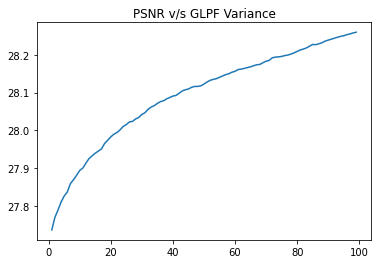

In [ ]:
# Plotting psnr vs variance values used in glpf
plt.plot(noise_var, psnr)
plt.title('PSNR v/s GLPF Variance')
plt.show()

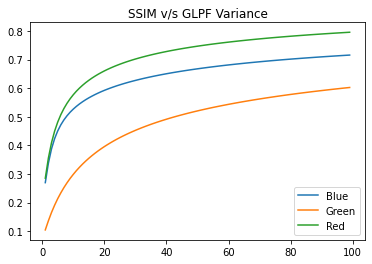

In [ ]:
# Plotting ssim vs variance values used in glpf
plt.plot(noise_var, ssim)
plt.title('SSIM v/s GLPF Variance')
plt.legend(['Blue', 'Green', 'Red'])
plt.show()

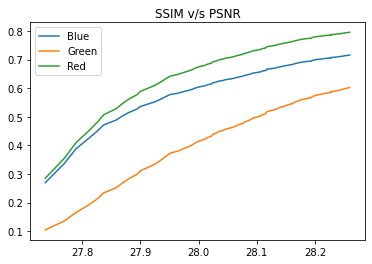

In [ ]:
# plotting ssim vs psnr values for glpf
plt.plot(psnr, ssim)
plt.title('SSIM v/s PSNR')
plt.legend(['Blue', 'Green', 'Red'])
plt.show()

c. The two thresholding methods

In [ ]:
varimg = cv2.imread('1.jpg', 0)
# Reading image
# Adding white gaussian noise of variance 30 to the base image
base_var = 30
base_img = awgn(varimg, base_var)
# Window size 3 is chosen as it gives best results
window_size = 3
# Noise variance is varied from 1 to 100
noise_var = range(1, 100)
# psnr and ssim lists will contain psnr and ssim values corresponding to each variance value
psnr, ssim = [], []
for var in noise_var:
    # threshold is defined as suggested by Donoho et al
    threshold = np.sqrt( var * 2 * np.log(window_size**2) )
    # Calculating hard_thresholding with above defined thresholding value
    ht_img = hard_thresholding(base_img, threshold)
    # Calculating soft_thresholding with above defined thresholding value
    st_img = soft_thresholding(base_img, threshold)
    psnr.append([meas_psnr(ht_img, varimg), meas_psnr(st_img, varimg)])
    ssim.append([meas_ssim(ht_img, varimg), meas_ssim(st_img, varimg)])
    # Appending psnr and ssim values to the specified lists
ssim = np.array(ssim)

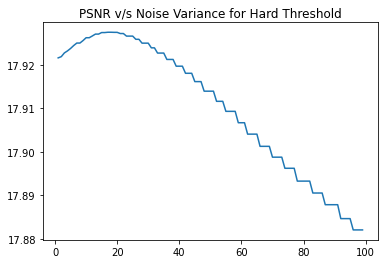

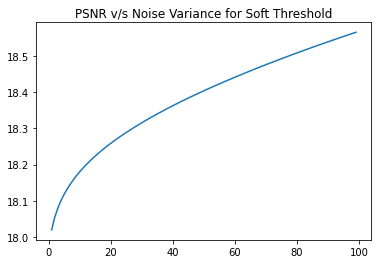

In [ ]:
# Plotting psnr vs noise variance values for hard thresholding
plt.plot(noise_var, [ i[0] for i in psnr ])
plt.title('PSNR v/s Noise Variance for Hard Threshold')
plt.show()
# Plotting psnr vs noise variance values for soft thresholding 
plt.plot(noise_var, [ i[1] for i in psnr ])
plt.title('PSNR v/s Noise Variance for Soft Threshold')
plt.show()

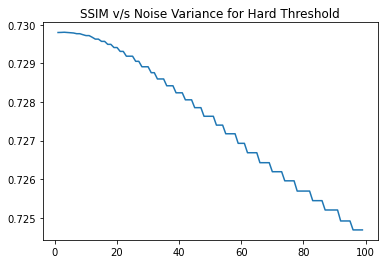

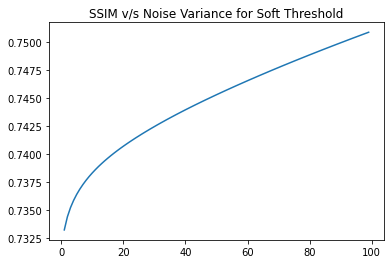

In [ ]:
# Plotting ssim vs noise variance values for hard thresholding
plt.plot(noise_var, ssim[:, 0, 0])
plt.title('SSIM v/s Noise Variance for Hard Threshold')
plt.show()
# Plotting ssim vs noise variance values for soft thresholding
plt.plot(noise_var, ssim[:, 1, 0])
plt.title('SSIM v/s Noise Variance for Soft Threshold')
plt.show()

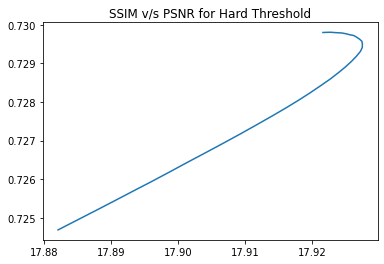

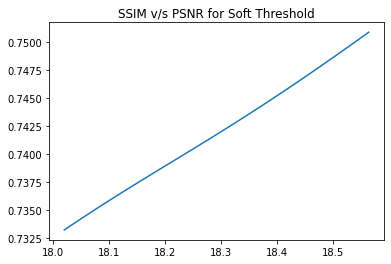

In [ ]:
# Plotting psnr vs ssim values for hard thresholding
plt.plot([ i[0] for i in psnr ], ssim[:, 0, 0])
plt.title('SSIM v/s PSNR for Hard Threshold')
plt.show()
# Plotting psnr vs ssim values for soft thresholding
plt.plot([ i[1] for i in psnr ], ssim[:, 1, 0])
plt.title('SSIM v/s PSNR for Soft Threshold')
plt.show()

e.  The method of Chen et al.

In [ ]:
varimg = cv2.imread('1.jpg', 0)
# Reading input image file
# Adding white gaussian noise with variance 30 to the input image
base_var = 30
base_img = awgn(varimg, base_var)
# Window size 3 is chosen as it gives best results as argued by Chen et al
window_size = 3
# Noise variance is varied from 1 to 100
noise_var = range(1, 100)
psnr, ssim = [], []
# psnr and ssim lists will contain psnr and ssim values for each variance value
for var in noise_var:
    chenimg = neigh_shrink(base_img, var)
    psnr.append(meas_psnr(chenimg, varimg))
    ssim.append(meas_ssim(chenimg, varimg))

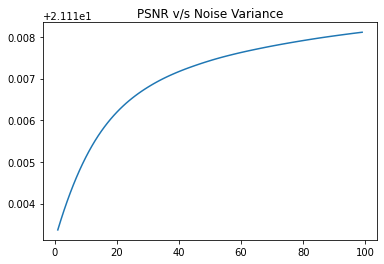

In [ ]:
# Plotting psnr vs noise variance values 
plt.plot(noise_var, psnr)
plt.title('PSNR v/s Noise Variance')
plt.show()

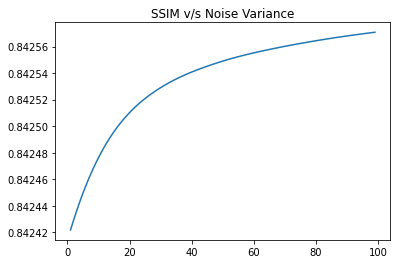

In [ ]:
# Plotting ssim vs noise variance values 
plt.plot(noise_var, ssim)
plt.title('SSIM v/s Noise Variance')
plt.show()

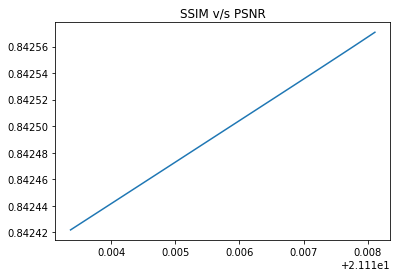

In [ ]:
# Plotting ssim vs psnr values
plt.plot(psnr, ssim)
plt.title('SSIM v/s PSNR')
plt.show()

e.  When the method is independently applied to RGB channels, versus when the method is applied to Ichannel of HSI transform.

In [ ]:
varimg = cv2.imread('1.jpg', 1)
# Loading image in RGB format
# Adding white gaussian noise with variance 30 to the above image
base_var = 30
base_img = awgn(varimg, base_var)
# Window size 3 is chosen as it gives best results
window_size = 3
# Noise variance values is varied from 1 to 100 in steps of 4
# Steps of 4 are used in order to decrease processing time
noise_var = range(1, 101, 4)
psnrbgr, ssimbgr = [], []
psnrhsv, ssimhsv = [], []
# psnrbgr stores psnr values independently applied to RGB channels for the RGB image
# ssimbrg stores ssim values independently applied to RGB channels for the RGB image
# psnrhsv stores psnr values independently applied to V channel for the HSV image
# ssimhsv stores ssim values independently applied to V channel for the HSV image
for var in noise_var:
    chenimg = base_img.copy()
    # We are applying chen et al method indepdently for each channel 
    for channel in range(base_img.shape[-1]):
        chenimg[:, :, channel] = neigh_shrink(base_img[:, :, channel], var)
    # Computing psnr and ssim values for rgb channels
    psnrbgr.append(meas_psnr(chenimg, varimg))
    ssimbgr.append(meas_ssim(chenimg, varimg))
    # Converting RGB image to HSV Image
    hsvimg = cv2.cvtColor(base_img, cv2.COLOR_BGR2HSV)
    # Applying chen et al method only to V channel of HSV Image
    hsvimg[:, :, 2] = neigh_shrink(hsvimg[:, :, 2], var)
    # Converting HSV image back to RGB image
    chenimg = cv2.cvtColor(hsvimg, cv2.COLOR_HSV2BGR)
    # Calculating the psnr and ssim values of the hsv image 
    psnrhsv.append(meas_psnr(chenimg, varimg))
    ssimhsv.append(meas_ssim(chenimg, varimg))   

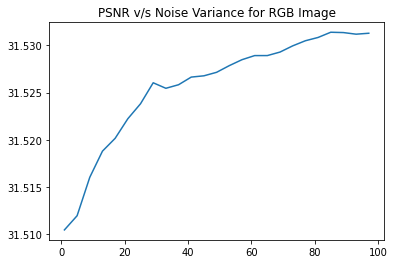

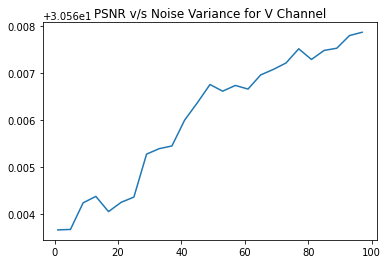

In [ ]:
# Plotting psnr vs variance values for rgb image
plt.plot(range(1, 101, 4), psnrbgr)
plt.title('PSNR v/s Noise Variance for RGB Image')
plt.show()
# Plotting psnr vs variance values for hsv image 
plt.plot(range(1, 101, 4), psnrhsv)
plt.title('PSNR v/s Noise Variance for V Channel')
plt.show()

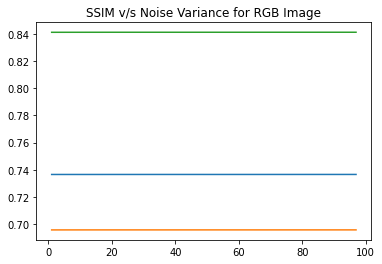

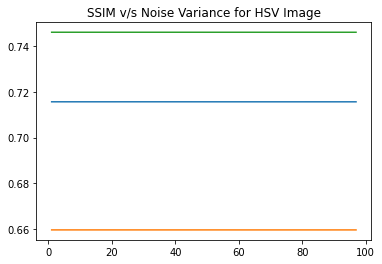

In [ ]:
# Plotting ssim vs noise variance values for the RGB image
plt.plot(range(1, 101, 4), ssimbgr)
plt.title('SSIM v/s Noise Variance for RGB Image')
plt.show()
# Plotting ssim vs noise variance values for V channel of HSV Image
plt.plot(range(1, 101, 4), ssimhsv)
plt.title('SSIM v/s Noise Variance for HSV Image')
plt.show()

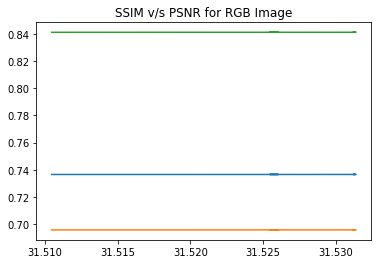

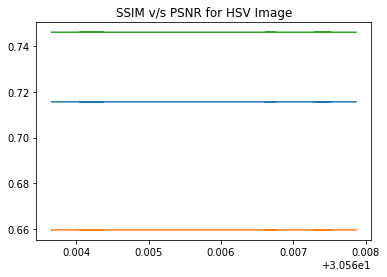

In [ ]:
# Plotting ssim vs psnr values for RGB Image
plt.plot(psnrbgr, ssimbgr)
plt.title('SSIM v/s PSNR for RGB Image')
plt.show()
# Plotting ssim vs psnr values for V channel of HSV Image
plt.plot(psnrhsv, ssimhsv)
plt.title('SSIM v/s PSNR for HSV Image')
plt.show()

The variation in ssim is minute and unnoticeable when they are plotted together

#4.

GLPF var =  10 VARIANCE =  1


/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


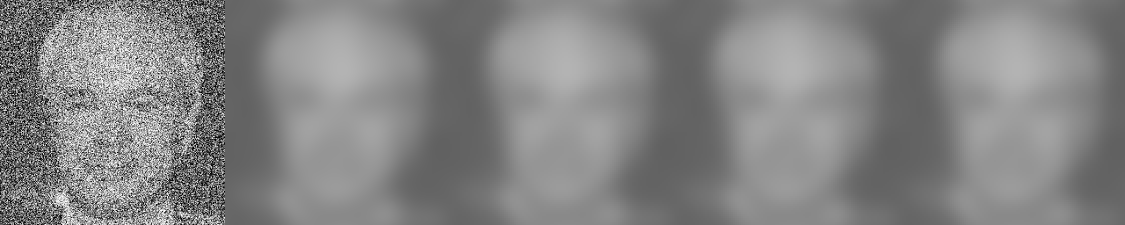

GLPF var =  10 VARIANCE =  21


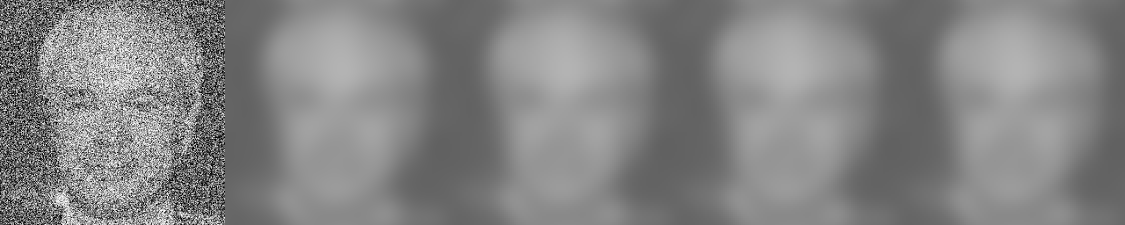

GLPF var =  10 VARIANCE =  41


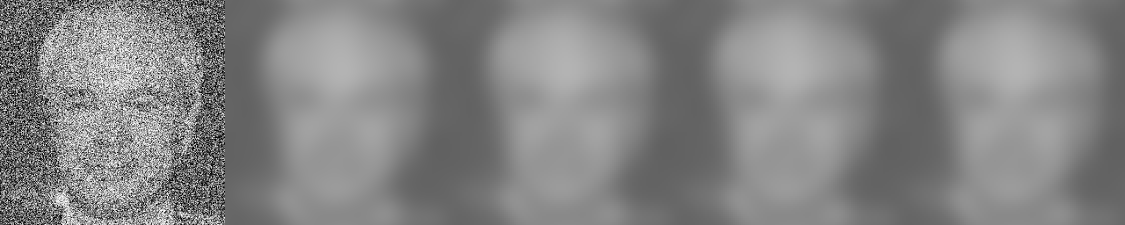

GLPF var =  10 VARIANCE =  61


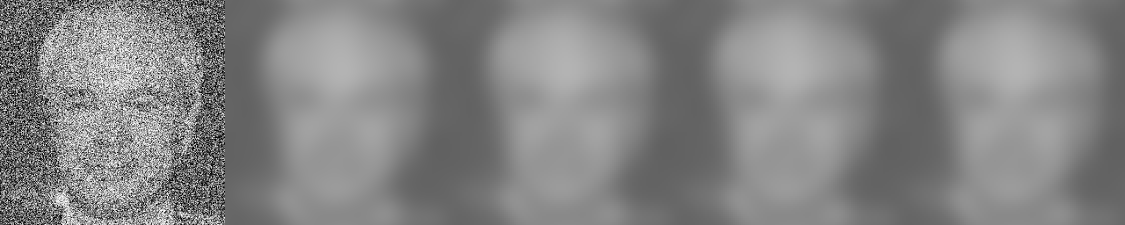

GLPF var =  10 VARIANCE =  81


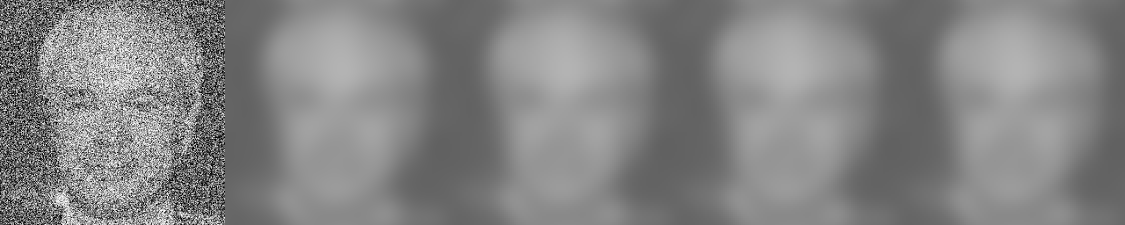

GLPF var =  210 VARIANCE =  1


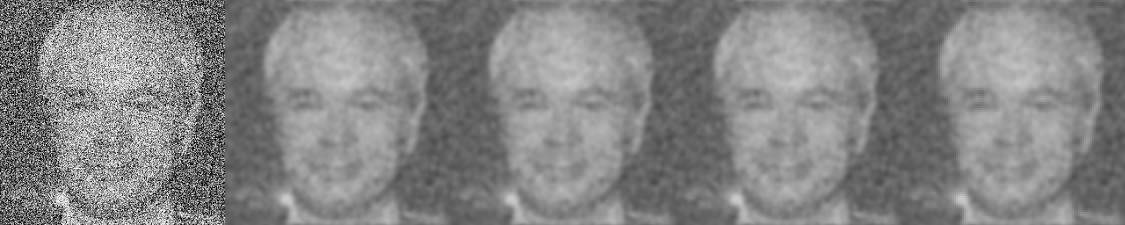

GLPF var =  210 VARIANCE =  21


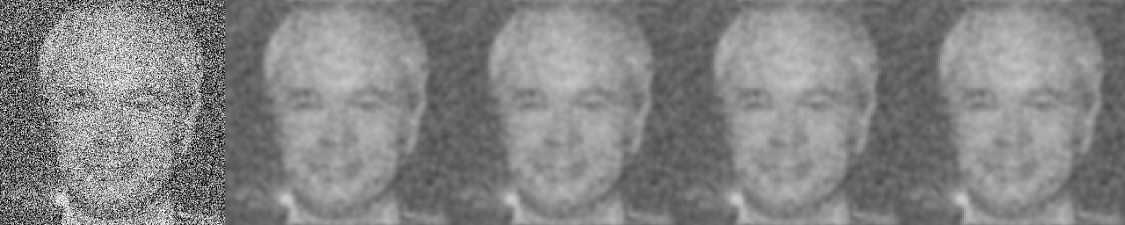

GLPF var =  210 VARIANCE =  41


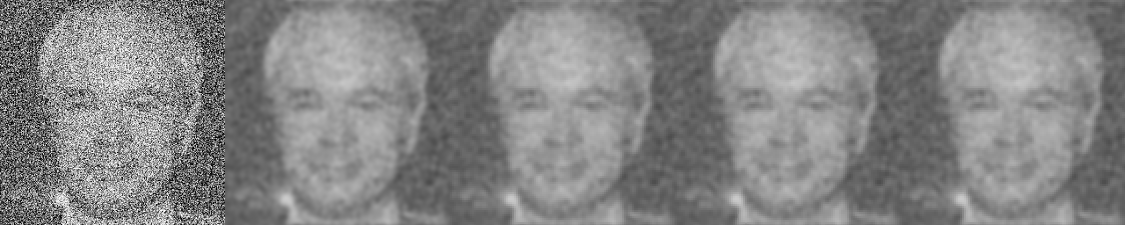

GLPF var =  210 VARIANCE =  61


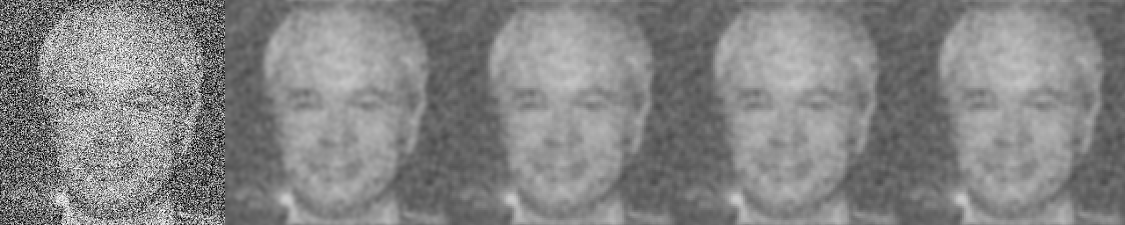

GLPF var =  210 VARIANCE =  81


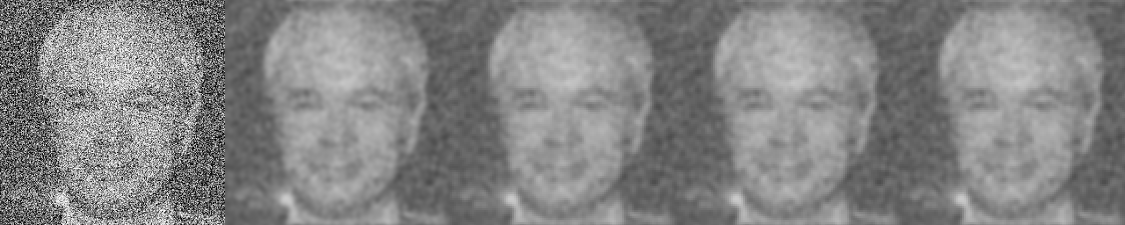

GLPF var =  410 VARIANCE =  1


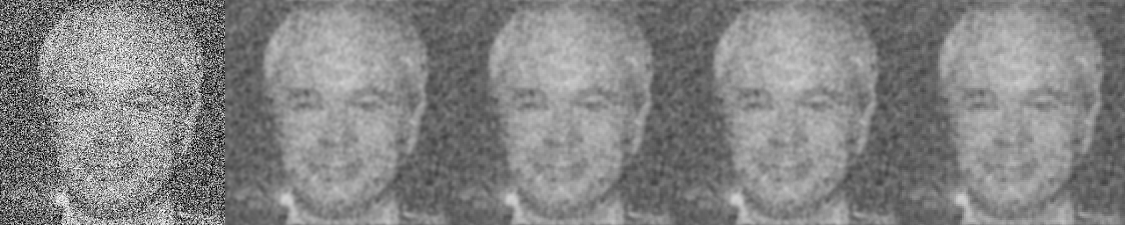

GLPF var =  410 VARIANCE =  21


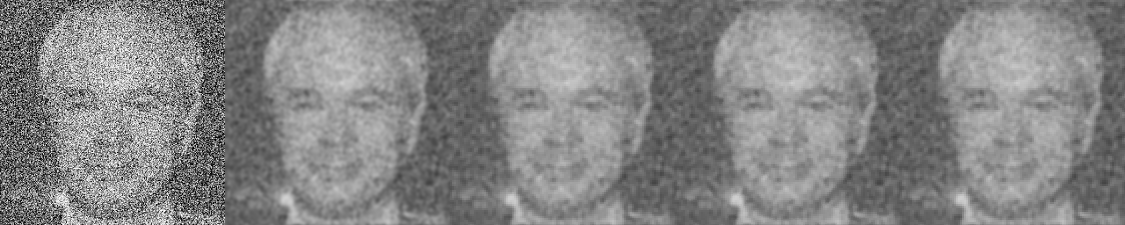

GLPF var =  410 VARIANCE =  41


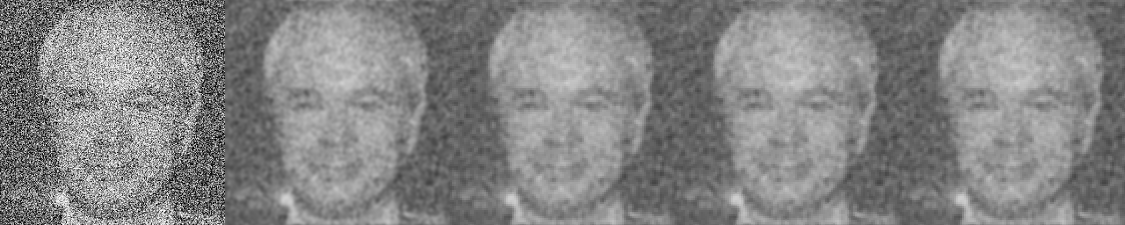

GLPF var =  410 VARIANCE =  61


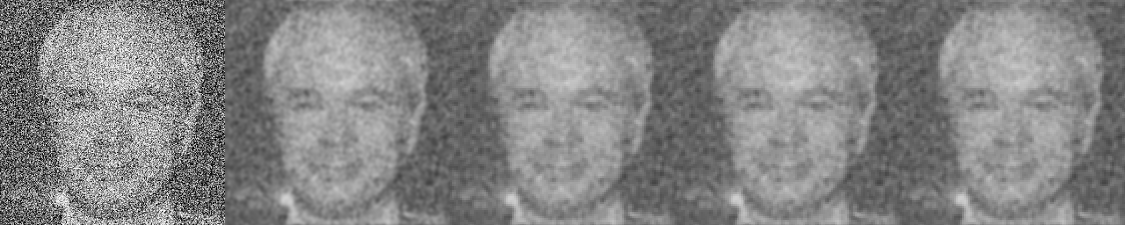

GLPF var =  410 VARIANCE =  81


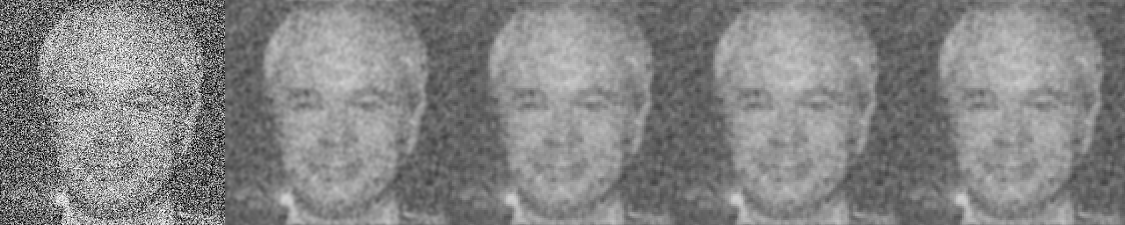

GLPF var =  610 VARIANCE =  1


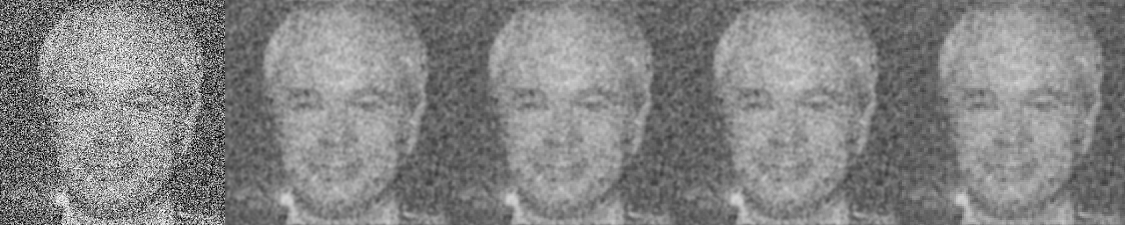

GLPF var =  610 VARIANCE =  21


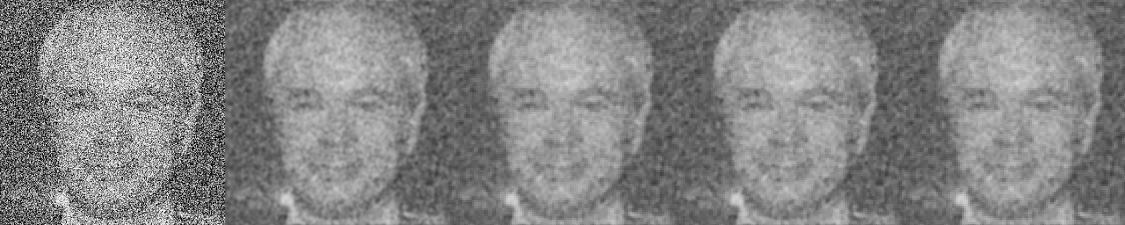

GLPF var =  610 VARIANCE =  41


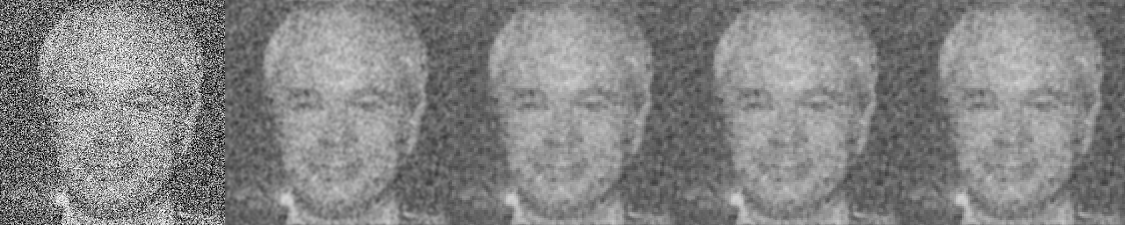

GLPF var =  610 VARIANCE =  61


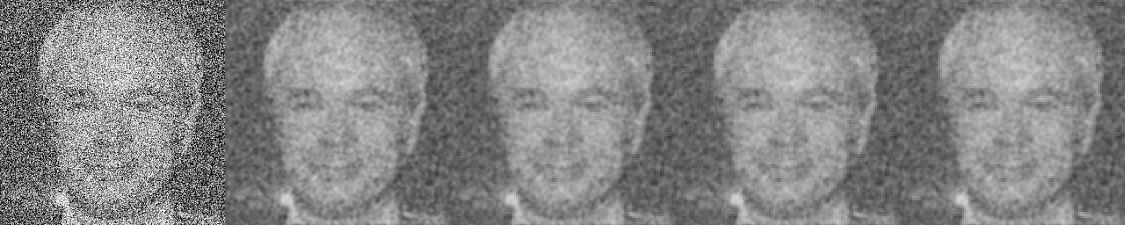

GLPF var =  610 VARIANCE =  81


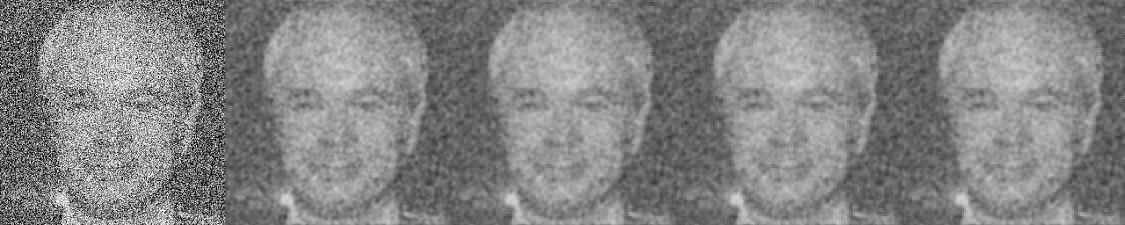

GLPF var =  810 VARIANCE =  1


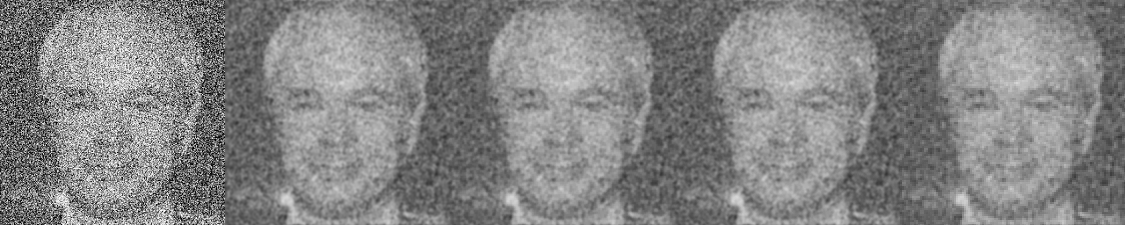

GLPF var =  810 VARIANCE =  21


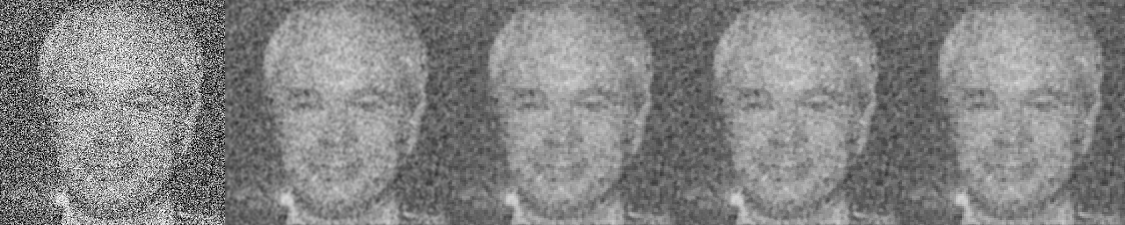

GLPF var =  810 VARIANCE =  41


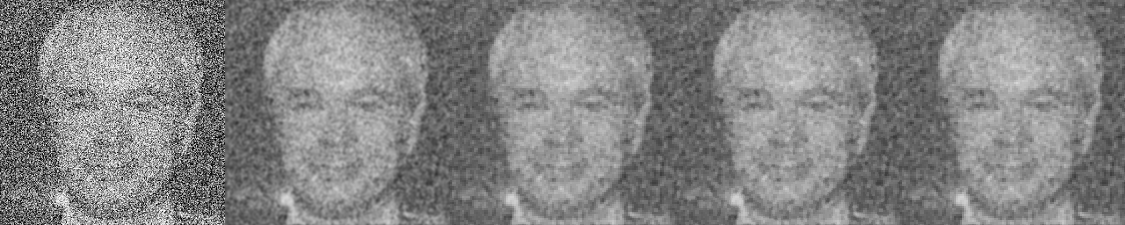

GLPF var =  810 VARIANCE =  61


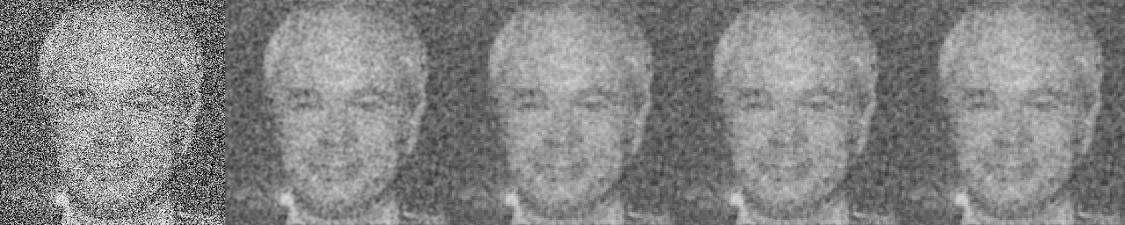

GLPF var =  810 VARIANCE =  81


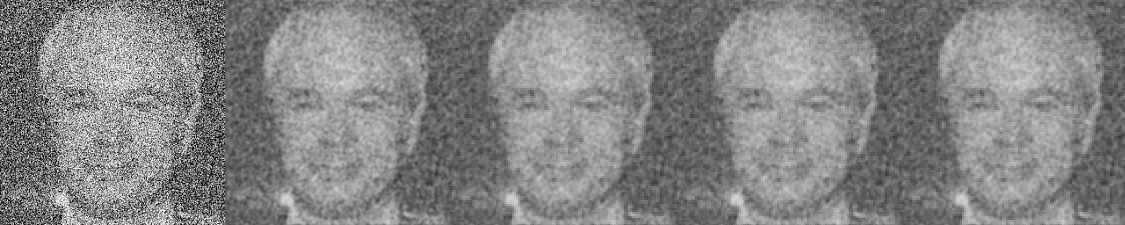

In [ ]:
rnimg = cv2.imread('realnoisyimage.jpg', 0)
# Loadding real noise imaage
# Varying noise variance from 1 to 100 with steps of 20
noise_var = range(1, 101, 20)
# Window size of 3 is chosen as it gives best results
window_size = 3
# Vari is varied from 1 to noise_var
for vari in noise_var:
    # Doing gaussian low pass filter with variance vari*10
    glpfimg = glpf(rnimg, vari*10)
    for var in noise_var:
        # Soft_thresholding the glpf image with variable variance 
        stimg = soft_thresholding(glpfimg, np.sqrt(2 * var * np.log(window_size ** 2)))
        # Hard_thresholding the glfp image with variable variance
        htimg = hard_thresholding(glpfimg, np.sqrt(2 * var * np.log(window_size ** 2)))
        # Performing neight_shrinking to the glpf image with variable variance
        chimg = neigh_shrink(glpfimg, var)
        print('GLPF var = ', vari*10, 'VARIANCE = ', var)
        # Concatenating the 5 images and displaying it in a row for better visualization
        cv2_imshow(np.concatenate((rnimg, glpfimg, stimg[:-1, :-1], htimg[:-1, :-1], chimg[:-1, :-1]), 1))